In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# data wrangling for the original data source

df = pd.read_csv("online_retail_listing.csv", delimiter = ';', encoding= 'unicode_escape')
df.dropna(how='any', inplace=True)
df.rename(columns= {'Price':'Unit Price', 'Country,,,,':'Country', 'InvoiceDate':'Order Date'}, inplace=True)

df['Unit Price']=df['Unit Price'].str.replace(',','.')
df['Unit Price']=df['Unit Price'].astype('float64')
df['Quantity']=df['Quantity'].astype('int64')
df['Order Date']=df['Order Date'].astype('datetime64')

df['Today']= '2012-02-13 12:00:00'
df['Today']= df['Today'].astype('datetime64')
df['Monetary Value'] = df['Unit Price']*df['Unit Price']

df.drop_duplicates(inplace=True)
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'Order Date',
       'Unit Price', 'Customer ID', 'Country', 'Today', 'Monetary Value'],
      dtype='object')

In [4]:
# integrate a dataset ready for calculation 

rfm=df[['Customer ID']]
rfm['First Order Date'] = df.groupby(['Customer ID'])['Order Date'].transform('min')
rfm['Last Order Date'] = df.groupby(['Customer ID'])['Order Date'].transform('max')

rfm['Interval'] = df['Today'] - rfm['Last Order Date']
rfm['Interval'] = rfm['Interval'].astype('timedelta64[D]')
rfm['Interval'] = rfm['Interval'].astype('int')

rfm['Lifetime'] = abs(rfm['First Order Date'] - rfm['Last Order Date'])
rfm['Lifetime'] = rfm['Lifetime'].astype('timedelta64[D]')
rfm['Lifetime'] = rfm['Lifetime'].astype('int')

rfm['Frequency'] = df.groupby(['Customer ID'])['Order Date'].transform('count')
rfm['Total Spent'] = df.groupby(['Customer ID'])['Monetary Value'].transform('sum').round(2)

rfm.drop_duplicates(inplace=True)
rfm.reset_index(inplace=True)
rfm.drop(['index'], axis=1, inplace=True)
rfm.sample(5)

,Customer ID,First Order Date,Last Order Date,Interval,Lifetime,Frequency,Total Spent
3880,16201.0,2010-10-20 12:00:00,2011-11-23 11:06:00,82,398,98,1188.21
4082,16931.0,2010-05-12 11:40:00,2011-11-20 14:43:00,84,557,867,6772.50
1923,17542.0,2010-08-03 12:08:00,2011-03-15 11:45:00,335,223,64,627.74
536,15369.0,2009-08-12 07:43:00,2011-07-18 15:11:00,209,705,104,2536608.50
368,15767.0,2009-04-12 14:56:00,2010-08-03 15:48:00,558,478,9,357.48


In [5]:
rfm["FrequencyScore"] = pd.cut(rfm["Frequency"], 
                                       bins=[-1, 
                                             np.percentile(rfm["Frequency"], 25), 
                                             np.percentile(rfm["Frequency"], 50), 
                                             np.percentile(rfm["Frequency"], 75), 
                                             rfm["Frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

In [6]:
rfm["MonetaryScore"] = pd.cut(rfm["Total Spent"], 
                                       bins=[-1, 
                                             np.percentile(rfm["Total Spent"], 25), 
                                             np.percentile(rfm["Total Spent"], 50), 
                                             np.percentile(rfm["Total Spent"], 75),
                                             rfm["Total Spent"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

In [7]:
rfm["RecencyScore"] = pd.cut(rfm["Interval"], 
                                       bins=[-1, 
                                             np.percentile(rfm["Interval"], 25), 
                                             np.percentile(rfm["Interval"], 50), 
                                             np.percentile(rfm["Interval"], 75),
                                             rfm["Interval"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")

In [8]:
# calculate RFM scores 

rfm['RFM Score'] = rfm["FrequencyScore"] + rfm["MonetaryScore"] + rfm["RecencyScore"]

# segmentize customer group based on RFM scores

rfm["Loyalty"] = pd.cut(rfm["RFM Score"], 
                                       bins=[-1, 
                                             np.percentile(rfm["RFM Score"], 33), 
                                             np.percentile(rfm["RFM Score"], 66), 
                                             rfm["RFM Score"].max()], 
                                       labels=['Silver', 'Gold', 'Platinum']).astype("str")

In [9]:
rfm

,Customer ID,First Order Date,Last Order Date,Interval,Lifetime,Frequency,Total Spent,FrequencyScore,MonetaryScore,RecencyScore,RFM Score,Loyalty
0,13085.0,2009-01-12 07:45:00,2011-05-07 12:11:00,281,845,88,690628.40,3,4,2,9,Gold
1,13078.0,2009-01-12 09:06:00,2011-12-10 14:48:00,64,1062,821,19615.11,4,4,4,12,Platinum
2,15362.0,2009-01-12 09:08:00,2010-09-17 10:37:00,514,613,40,840.92,2,2,1,5,Silver
3,18102.0,2009-01-12 09:24:00,2011-11-28 12:55:00,76,1050,1027,22629772.57,4,4,4,12,Platinum
4,12682.0,2009-01-12 09:28:00,2011-12-08 15:22:00,66,1060,962,28539.73,4,4,4,12,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...
5918,12587.0,2011-02-12 12:47:00,2011-02-12 12:47:00,365,0,4,1612.98,1,3,2,6,Silver
5919,13560.0,2011-02-12 13:11:00,2011-02-12 13:11:00,365,0,32,358.05,2,2,2,6,Silver
5920,15539.0,2011-02-12 13:36:00,2011-02-12 13:36:00,365,0,41,101.37,2,1,2,5,Silver
5921,13017.0,2011-02-12 15:53:00,2011-02-12 15:53:00,365,0,1,18.06,1,1,2,4,Silver


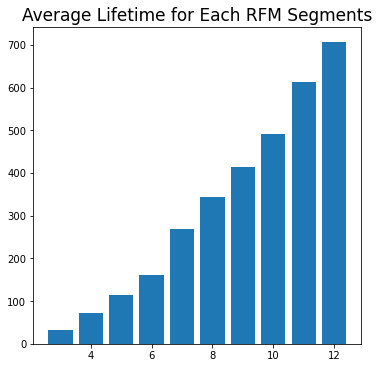

In [10]:
# discover if there is a correlation between lifetime and customers' RFM scores

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.axis('on')
ax.bar(rfm['RFM Score'], rfm.groupby(['RFM Score'])['Lifetime'].transform('mean'))
ax.set_title('Average Lifetime for Each RFM Segments',
             fontdict={'fontsize': '17', 'fontweight' : '3'})
plt.show()

[Text(0, 0, '1815'), Text(0, 0, '1697'), Text(0, 0, '2411')]

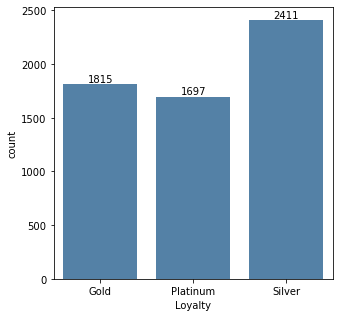

In [11]:
# visualization of current customer base composition

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.countplot(x="Loyalty", data=rfm, color='steelblue')
ax.bar_label(ax.containers[0])

(1.0, 1000.0)

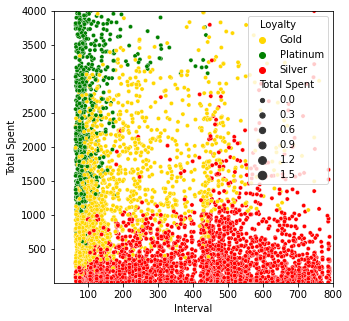

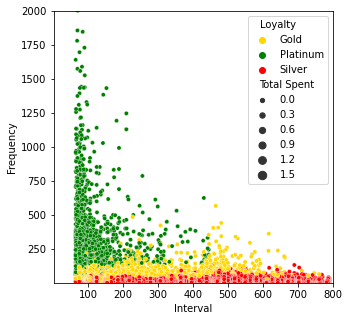

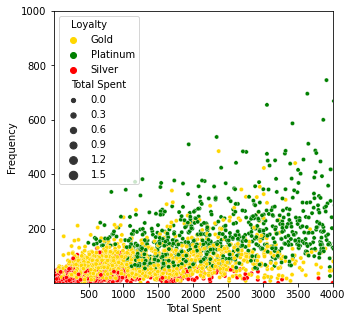

In [12]:
# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x='Interval', y='Total Spent', data=rfm, hue='Loyalty', size='Total Spent', palette=["gold", "green", "red"])
ax.set_xlim(1, 800)
ax.set_ylim(1, 4000)

# Frequency vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x='Interval', y='Frequency', data=rfm, hue='Loyalty', size='Total Spent', palette=["gold", "green", "red"])
ax.set_xlim(1, 800)
ax.set_ylim(1, 2000)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x='Total Spent', y='Frequency', data=rfm, hue='Loyalty', size='Total Spent', palette=["gold", "green", "red"])
ax.set_xlim(1, 4000)
ax.set_ylim(1, 1000)